<a href="https://colab.research.google.com/github/subhash505/datat_analytics/blob/main/Dog_Vs_Cat_Project_Zero_to_Gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## __Cats and Dogs Classification__

The Asirra (animal species image recognition for restricting access) dataset was introduced in 2013 for a machine learning competition. The dataset includes 25,000 images with equal numbers of labels for cats and dogs.

Dataset: [Cats and Dogs dataset](https://www.kaggle.com/c/dogs-vs-cats/data)

### Prepare dataset for training model:

### Given data is in Zip format. So first we have to unzip the files.

In [ ]:
### Unzipping Dataset
'''
import zipfile

with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")
'''

'\nimport zipfile\n\nwith zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:\n    z.extractall(".")\n    \nwith zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:\n    z.extractall(".")\n'

### Import the libraries:

In [ ]:
import os
import cv2
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline


### Importing the Dataset into Train and Test

In [ ]:
DIR_TRAIN = "train/"
DIR_TEST = "test"

In [ ]:
!rmdir train/.ipynb_checkpoints
!rmdir test/.ipynb_checkpoints

rmdir: failed to remove 'train/.ipynb_checkpoints': No such file or directory


### Checking Data Format

In [ ]:
imgs = os.listdir(DIR_TRAIN) 
test_imgs = os.listdir(DIR_TEST)

print(imgs[:5])
print(test_imgs[:5])

['dog.5.jpg', 'dog.2.jpg', 'cat.2.jpg', 'cat.3.jpg', 'cat.5.jpg']
['dog.5.jpg', 'cat.5.jpg', 'cat.4.jpg', 'dog.4.jpg']


### Class Distribution of Dog and Cat

In [ ]:
dogs_list = [img for img in imgs if img.split(".")[0] == "dog"]
cats_list = [img for img in imgs if img.split(".")[0] == "cat"]

print("No of Dogs Images: ",len(dogs_list))
print("No of Cats Images: ",len(cats_list))

class_to_int = {"dog" : 0, "cat" : 1}
int_to_class = {0 : "dog", 1 : "cat"}

No of Dogs Images:  5
No of Cats Images:  5


### Transforms for image - ToTensor and other augmentations

In [ ]:
def get_train_transform():
    return T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(15),
        T.RandomCrop(204),
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])
    
def get_val_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])

### Dataset Class - for retriving images and labels

In [ ]:
class CatDogDataset(Dataset):
    
    def __init__(self, imgs, class_to_int, mode = "train", transforms = None):
        
        super().__init__()
        self.imgs = imgs
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        image_name = self.imgs[idx]
        
        ### Reading, converting and normalizing image
        #img = cv2.imread(DIR_TRAIN + image_name, cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (224,224))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img /= 255.
        img = Image.open(DIR_TRAIN + image_name)
        img = img.resize((224, 224))
        
        if self.mode == "train" or self.mode == "val":
        
            ### Preparing class label
            label = self.class_to_int[image_name.split(".")[0]]
            label = torch.tensor(label, dtype = torch.float32)

            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label
        
        elif self.mode == "test":
            
            ### Apply Transforms on image
            img = self.transforms(img)

            return img
            
        
    def __len__(self):
        return len(self.imgs)
    

### Splitting data into training set and vali sets

In [ ]:
train_imgs, val_imgs = train_test_split(imgs, test_size = 0.25)

### Prepare dataset for training model:

In [ ]:
train_dataset = CatDogDataset(train_imgs, class_to_int, mode = "train", transforms = get_train_transform())
val_dataset = CatDogDataset(val_imgs, class_to_int, mode = "val", transforms = get_val_transform())
test_dataset = CatDogDataset(test_imgs, class_to_int, mode = "test", transforms = get_val_transform())

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Visualize some Random Images from Training set

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


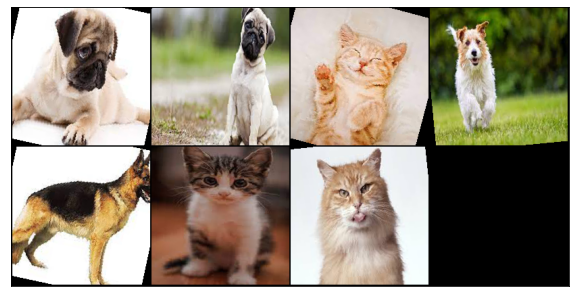

In [ ]:
for images, labels in train_data_loader:
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break
    

### Check for GPU availability

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Define a function to calculate accuracy

In [ ]:
def accuracy(preds, trues):
    
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)
    
    

### Define a Function to train over Epoch

In [ ]:
def train_one_epoch(train_data_loader):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in train_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        #Backward
        _loss.backward()
        optimizer.step()
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time
        

### Define a Function over Validation - One Epoch

In [ ]:
def val_one_epoch(val_data_loader, best_val_acc):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in val_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"resnet50_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc
        

### RESNET50 Pretrained Model

Resnet models were proposed in “Deep Residual Learning for Image Recognition”. Here we have the 5 versions of resnet models, which contains 5, 34, 50, 101, 152 layers respectively. 
We are using ResNet 50 model.

(Check Reference: 1)

In [ ]:
model = resnet50(pretrained = True)

# Modifying Head - classifier

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### Defining model parameters Like Optimizer, Learning rate, Loss Function, epochs:

(Check Reference: 2)

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 10

### Train Training and Validation sets
(Check Referance:3)

In [ ]:
best_val_acc = 0
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Training
Epoch 1
Loss : 0.8084
Acc : 42.8571
Time : 6.2812

Validating
Epoch 1
Loss : 0.5997
Acc : 66.6667
Time : 1.055

Training
Epoch 2
Loss : 0.4716
Acc : 85.7143
Time : 4.964

Validating
Epoch 2
Loss : 0.5094
Acc : 100.0
Time : 1.0709

Training
Epoch 3
Loss : 0.2917
Acc : 100.0
Time : 6.2779

Validating
Epoch 3
Loss : 0.4327
Acc : 100.0
Time : 1.0687

Training
Epoch 4
Loss : 0.1784
Acc : 100.0
Time : 4.9603

Validating
Epoch 4
Loss : 0.3674
Acc : 100.0
Time : 1.0628

Training
Epoch 5
Loss : 0.1159
Acc : 100.0
Time : 4.9081

Validating
Epoch 5
Loss : 0.3131
Acc : 100.0
Time : 1.0723

Training
Epoch 6
Loss : 0.0741
Acc : 100.0
Time : 4.9828

Validating
Epoch 6
Loss : 0.2684
Acc : 100.0
Time : 1.0878

Training
Epoch 7
Loss : 0.0498
Acc : 100.0
Time : 4.9925

Validating
Epoch 7
Loss : 0.2311
Acc : 100.0
Time : 1.0836

Training
Epoch 8
Loss : 0.0305
Acc : 100.0
Time : 5.02

Validating
Epoch 8
Loss : 0.201
Acc : 100.0
Time : 1.0542

Training
Epoch 9
Loss : 0.0206
Acc : 100.0
Time : 4.97

### Lets Plot The Accuracies and Losses

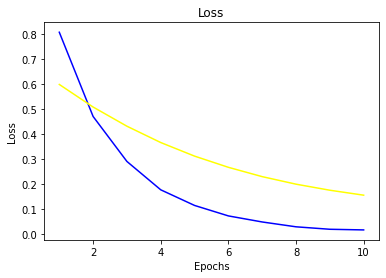

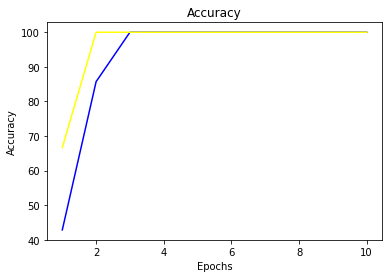

In [ ]:
### Plotting Results

#Loss
plt.title("Loss")
plt.plot(np.arange(1, 11, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, 11, 1), val_logs["loss"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, 11, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, 11, 1), val_logs["accuracy"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


References: 
1. [RESNET50](https://pytorch.org/hub/pytorch_vision_resnet/)

2.[Optimizer, Learinig rate, Loss Function and Epoch](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)

3.[Training and Validation dataset](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets)

4. [Pytorch Documentation](http://pytorch.org)